In [137]:
#Overview: This is a workbook to demonstrate the following supervised/unsupervised learning methods:
#1 K-Means Clustering (Unsupervised)
#2 Support Vector Machines (SVMs) (Supervised)
#3 (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
#4 Logistic Regression (Supervised)

In [61]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import os

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

import warnings
import random
warnings.filterwarnings('ignore')


In [65]:
#Custom functions required as part of demonstration
#functions used to process text and create the required TFIDF and Doc2vec Matrices
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range= ngram_range)

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix


def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels



In [16]:
#Section 1: K-Means
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame



In [35]:
def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.


    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

    dist = 1 - cosine_similarity(TFIDF_matrix)

    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'}


    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point



In [62]:
#Section 3, 4, 5: Classifiers
def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)

    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    
    return accy

In [10]:
#this section of the code prepares the required variables to run functions set for each 
#section of code

#load data frame and process the text
os.chdir('/Users/paulhuynh/Documents/School/2021 Summer/Section 56/')

#read in class corpus csv into python
data=pd.read_csv('453_Sec56_Class_Corpus_v2.csv')



In [11]:
data.head(10)

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title
0,0,AJP_Doc10_For_Arrival_Is_A,Title: Arrival is a waste of space\r\n\tAuthor...,AJP_Doc10_For_Arrival_Is_A,Austin Pelletier,Sci-Fi,Negative,Arrival
1,1,AJP_Doc1_Denis_Villeneuves_Arrival,Title: Denis Villeneuves Arrival Is Brainy Sci...,AJP_Doc1_Denis_Villeneuves_Arrival,Austin Pelletier,Sci-Fi,Positive,Arrival
2,2,AJP_Doc2_Arrival_Arrives_Just,Title: Arrival Arrives Just in Time Despite a ...,AJP_Doc2_Arrival_Arrives_Just,Austin Pelletier,Sci-Fi,Positive,Arrival
3,3,AJP_Doc3_The_Prescient_Wisdom,Title: The prescient wisdom of Arrival: How it...,AJP_Doc3_The_Prescient_Wisdom,Austin Pelletier,Sci-Fi,Positive,Arrival
4,4,AJP_Doc4_Arrival_Is_A,Title: Arrival is a stunning science fiction m...,AJP_Doc4_Arrival_Is_A,Austin Pelletier,Sci-Fi,Positive,Arrival
5,5,AJP_Doc5_Arrival_Is_The,Title: Arrival is the smartest big-budget Sci-...,AJP_Doc5_Arrival_Is_The,Austin Pelletier,Sci-Fi,Positive,Arrival
6,6,AJP_Doc6_Denis_Villeneuve_Wants,Title: Denis Villeneuve wants to make a presti...,AJP_Doc6_Denis_Villeneuve_Wants,Austin Pelletier,Sci-Fi,Negative,Arrival
7,7,AJP_Doc7_Star_Studded_Arrival,Title: Star-Studded Arrival Brings Mood But No...,AJP_Doc7_Star_Studded_Arrival,Austin Pelletier,Sci-Fi,Negative,Arrival
8,8,AJP_Doc8_Arrival_The_Film,Title: 'Arrival': The film lacks a sense of th...,AJP_Doc8_Arrival_The_Film,Austin Pelletier,Sci-Fi,Negative,Arrival
9,9,AJP_Doc9_For_A_Film,"Title: For a film about space, Arrival is surp...",AJP_Doc9_For_A_Film,Austin Pelletier,Sci-Fi,Negative,Arrival


In [70]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))



#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()


#generate tfidf for analysis
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

In [37]:
#Section 1: Execute K-means clustering
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =20)

In [38]:
#access each cluster by changing the dictionary key value from 0 to k
cluster_title[2]

['JM_Doc10_The_Conjuring_3_positive',
 'JM_Doc1_The_Conjuring_3_Negetive',
 'JM_Doc2_The_Conjuring_3_Negative',
 'JM_Doc3_The_Conjuring_3_Negative',
 'JM_Doc4_The_Conjuring_3_Negative',
 'JM_Doc5_The_Conjuring_3_Negative',
 'JM_Doc6_The_Conjuring_3_positive',
 'JM_Doc7_The_Conjuring_3_positive',
 'JM_Doc8_The_Conjuring_3_positive',
 'JM_Doc9_The_Conjuring_3_positive']

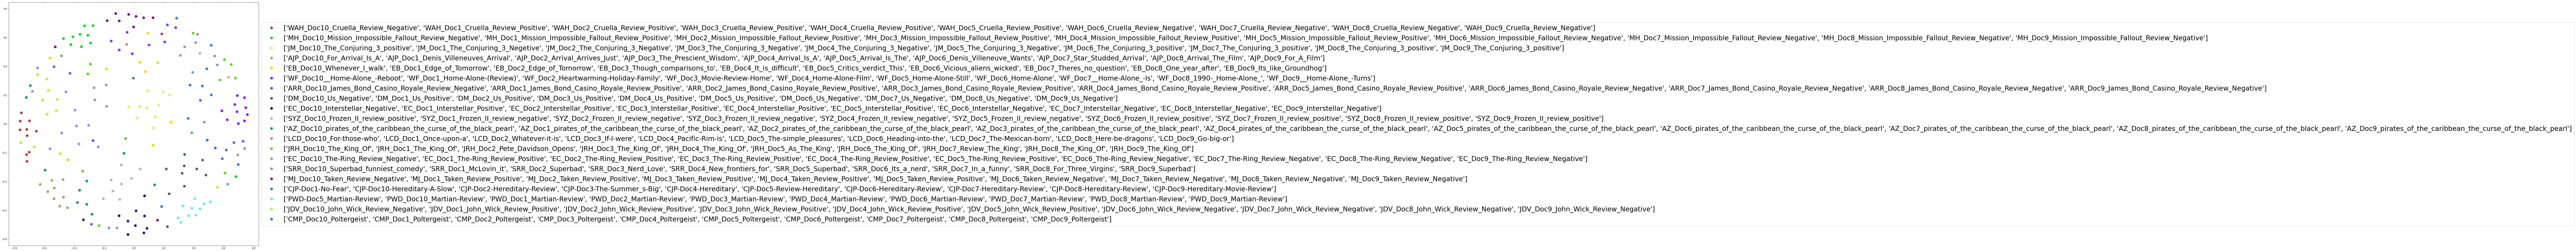

In [39]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

In [51]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)

print(labels)

0      0
1      1
2      1
3      1
4      1
      ..
195    1
196    0
197    0
198    0
199    0
Name: Review Type (pos or neg), Length: 200, dtype: int64


In [71]:
#Section 2: Support Vector Machines
classifiers(tfidf_matrix, labels, 'svm')

svm


0.4393939393939394

In [72]:
#Section 3: Support Vector Machines
classifiers(tfidf_matrix, labels, 'logistic')
    


logistic


0.45454545454545453

In [59]:
#Section 4: Naive Bayes
classifiers(tfidf_matrix, labels, 'naive_bayes')
    


naive_bayes


0.42424242424242425

In [74]:
#Section 4: Naive Bayes
classifiers(tfidf_matrix, labels, 'randomforest')
    


randomforest


0.5454545454545454